In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May  4 21:28:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [1]:
import glob
from skimage.io import imread
import numpy as np
import albumentations as A
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D, Dropout, BatchNormalization, Dense, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
def norm_bands(tif):
    return (tif - tif.min())/(tif.max() - tif.min())

In [3]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


## Create X and Y sets

**To generate the X and Y sets without augmentation run the code below**

In [ ]:
# Image paths
files_leak = glob.glob("/content/drive/MyDrive/patches_clean/leak/*.tif")
files_nonleak = glob.glob("/content/drive/MyDrive/patches_clean/non_leak/*.tif")
files = files_leak + files_nonleak

In [ ]:
X = []
files_leak = glob.glob("/content/drive/MyDrive/patches_clean/leak/*.tif")
files_nonleak = glob.glob("/content/drive/MyDrive/patches_clean/non_leak/*.tif")
files = files_leak + files_nonleak

for file in files:
    image = imread(file)
    if image.shape == (21, 21, 14):
        X.append(image)
    else:
        next

X = np.array(X)
X.shape

(1650, 21, 21, 14)

In [ ]:
y_leak = [1 for i in range(0, 825)]
y_nonleak = [0 for i in range(0, 825)]
Y = y_leak + y_nonleak
Y_raw = np.array(Y).reshape((1650, 1))

**To load the augmented X and Y sets run the code below**

In [2]:
# Read from google drive
X = np.load("/content/drive/MyDrive/training/X.npy")
Y = np.load("/content/drive/MyDrive/training/Y.npy")

In [ ]:
# Run if you want to get get only S2 bands
X = X[:, :, :, :13]
#X = np.expand_dims(X, axis = -1)
X.shape

(3282, 21, 21, 13)

In [ ]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (3282, 21, 21, 14)
Y shape: (3282, 1)


## Define training, validation and test sets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 13)

In [4]:
# Shapes of sets
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_val: ", y_val.shape)
print("y_test: ", y_test.shape)

X_train:  (2362, 21, 21, 14)
X_val:  (263, 21, 21, 14)
X_test:  (657, 21, 21, 14)
y_train:  (2362, 1)
y_val:  (263, 1)
y_test:  (657, 1)


In [7]:
def see_balance_in_set(set):
    print(np.unique(set.ravel(), return_counts = True))

In [8]:
# Check if classes are balanced
see_balance_in_set(y_train)
see_balance_in_set(y_val)
see_balance_in_set(y_test)

(array([0, 1], dtype=int32), array([1191, 1171]))
(array([0, 1], dtype=int32), array([131, 132]))
(array([0, 1], dtype=int32), array([319, 338]))


## Own architecture

In [5]:
model = Sequential()

# 1st Conv layer
model.add(Conv2D(32, (3, 3), padding = "same", input_shape = (21, 21, 14)))
model.add(BatchNormalization()) 
model.add(Activation("relu"))

# 2nd Conv layer
model.add(Conv2D(32, (3, 3), padding = "valid"))
model.add(Activation("relu"))
model.add(Dropout(0.5))

# 3rd conv layer
model.add(Conv2D(64, (3, 3), padding = "same"))
model.add(Activation("relu"))
model.add(Dropout(0.5))

# 4th conv layer
model.add(Conv2D(64, (2, 2), padding = "valid"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.5))

# Dense layer
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 21, 32)        4064      
                                                                 
 batch_normalization (BatchN  (None, 21, 21, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 21, 21, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 19, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 19, 19, 32)        0         
                                                                 
 dropout (Dropout)           (None, 19, 19, 32)        0         
                                                        

In [101]:
#def scheduler(epoch, lr):
#    l = 0.00001
#    if epoch > 400:
#        l = 0.0001
#    if epoch > 200:
#        l = 0.001
    
#    return l

# scheduler that got 77% acc
def scheduler(epoch, lr):
   l = 0.0001
   if epoch > 75:
       l = 0.00001
   if epoch > 90:
       l = 0.000001
    
   return l

In [102]:
callback = LearningRateScheduler(scheduler, verbose = 1)

In [103]:
optim = optimizers.Adam()

In [104]:
model.compile(loss = "binary_crossentropy",
              optimizer = optim,
              metrics = ["acc"])

In [105]:
history = model.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs = 100,
                    callbacks = [callback],
                    batch_size = 64,
                    shuffle = True)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
37/37 [==============================] - 3s 16ms/step - loss: 1.0826 - acc: 0.5059 - val_loss: 0.7397 - val_acc: 0.5285 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/100
37/37 [==============================] - 0s 10ms/step - loss: 0.8541 - acc: 0.5220 - val_loss: 0.6952 - val_acc: 0.4981 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/100
37/37 [==============================] - 0s 9ms/step - loss: 0.7698 - acc: 0.5229 - val_loss: 0.6718 - val_acc: 0.5323 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/100
37/37 [==============================] - 0s 9ms/step - loss: 0.7321 - acc: 0.5377 - val_loss: 0.6738 - val_acc: 0.5513 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/100
37/37 [==============================] - 0s 9ms/step - loss: 0.7184 -

In [106]:
results = model.evaluate(X_test, y_test, batch_size = 64)
print("test_loss, test_acc:", results)

11/11 [==============================] - 0s 4ms/step - loss: 0.4866 - acc: 0.7717
test_loss, test_acc: [0.486581414937973, 0.7716894745826721]


In [107]:
# See predictions by class
model_pred = model.predict(X_test, batch_size = 64)

print(classification_report(y_test, np.where(model_pred > 0.5, 1, 0)))

11/11 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.81      0.69      0.75       319
           1       0.74      0.85      0.79       338

    accuracy                           0.77       657
   macro avg       0.78      0.77      0.77       657
weighted avg       0.78      0.77      0.77       657



dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


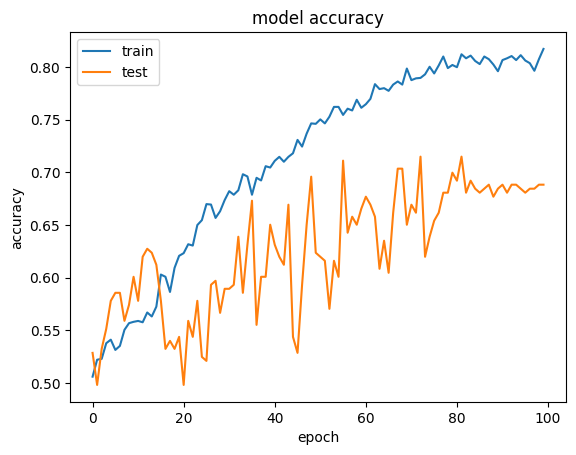

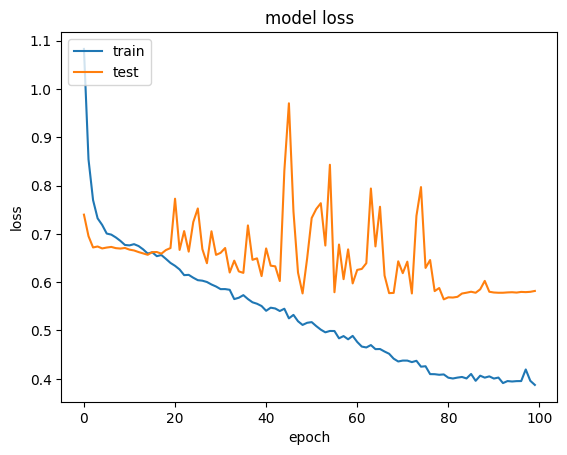

In [108]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [111]:
# Save 77% acc model
model.save("/content/drive/MyDrive/models/model_77acc.keras")

## Model Chen

Based on the paper Chen et al. (2020). Augmenting a deep-learning algorithm with canal inspection knowledge for reliable water leak detection from multispectral satellite images. https://doi.org/10.1016/j.aei.2020.101161

In [ ]:
model_chen = Sequential()

# 1st Conv layer
model_chen.add(Conv2D(32, kernel_size = (3, 3), input_shape = (21, 21, 14), padding = "same"))
model_chen.add(BatchNormalization())

model_chen.add(Activation("relu"))
model_chen.add(MaxPool2D(2, 2))

# 2nd Conv layer
model_chen.add(Conv2D(32, kernel_size = (3, 3), padding = "same"))
model_chen.add(Activation("relu"))
model_chen.add(MaxPool2D(2, 2))
model_chen.add(Dropout(0.5))


# 3rd Conv layer
model_chen.add(Conv2D(64, kernel_size = (3, 3), padding = "same"))
model_chen.add(BatchNormalization())
model_chen.add(Activation("relu"))
model_chen.add(MaxPool2D(2, 2))

# Dense layer
model_chen.add(Flatten())
model_chen.add(Dense(128, activation = "relu"))
model_chen.add(Dense(1, activation = "sigmoid"))

model_chen.summary()


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_110 (Conv2D)         (None, 21, 21, 32)        4064      
                                                                 
 batch_normalization_62 (Bat  (None, 21, 21, 32)       128       
 chNormalization)                                                
                                                                 
 activation_124 (Activation)  (None, 21, 21, 32)       0         
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 10, 10, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_111 (Conv2D)         (None, 10, 10, 32)        9248      
                                                                 
 activation_125 (Activation)  (None, 10, 10, 32)     

In [ ]:
optim = optimizers.Adam(learning_rate = 0.0001)

In [ ]:
model_chen.compile(loss = "binary_crossentropy",
                   optimizer = optim,
                   metrics = ["acc"])


In [ ]:
history_chen = model_chen.fit(X_train, 
                         y_train,
                         validation_data = (X_val, y_val),
                         epochs = 100,
                         batch_size = 32)

Epoch 1/100
74/74 [==============================] - 3s 10ms/step - loss: 0.7336 - acc: 0.5186 - val_loss: 0.6761 - val_acc: 0.5741
Epoch 2/100
74/74 [==============================] - 0s 5ms/step - loss: 0.6983 - acc: 0.5521 - val_loss: 0.6889 - val_acc: 0.5133
Epoch 3/100
74/74 [==============================] - 0s 5ms/step - loss: 0.6929 - acc: 0.5559 - val_loss: 0.6694 - val_acc: 0.5513
Epoch 4/100
74/74 [==============================] - 0s 5ms/step - loss: 0.6801 - acc: 0.5644 - val_loss: 0.6536 - val_acc: 0.5741
Epoch 5/100
74/74 [==============================] - 0s 5ms/step - loss: 0.6779 - acc: 0.5741 - val_loss: 0.6480 - val_acc: 0.5817
Epoch 6/100
74/74 [==============================] - 0s 5ms/step - loss: 0.6726 - acc: 0.5771 - val_loss: 0.6516 - val_acc: 0.5932
Epoch 7/100
74/74 [==============================] - 0s 5ms/step - loss: 0.6604 - acc: 0.5927 - val_loss: 0.6438 - val_acc: 0.5856
Epoch 8/100
74/74 [==============================] - 0s 5ms/step - loss: 0.6616 - 

In [ ]:
results_chen = model_chen.evaluate(X_test, y_test, batch_size = 64)
print("test_loss, test_acc:", results_chen)

11/11 [==============================] - 0s 6ms/step - loss: 0.6325 - acc: 0.7002
test_loss, test_acc: [0.6325364708900452, 0.7001522183418274]


## Simple architecture

In [52]:
model_simple = Sequential()

# 1st Conv Layer
model_simple.add(Conv2D(32, (3, 3), padding = "same", strides = (1, 1), input_shape = (21, 21, 14)))
model_simple.add(BatchNormalization())
model_simple.add(Activation("relu"))
model_simple.add(Dropout(0.2))

# 2nd Conv layer
model_simple.add(Conv2D(64, (3, 3), padding = "same", strides = (1, 1)))
model_simple.add(Activation("relu"))
model_simple.add(Dropout(0.3))

# 3rd Conv layer
model_simple.add(Conv2D(128, (3, 3), padding = "valid", strides = (3, 3)))
model_simple.add(BatchNormalization())
model_simple.add(Activation("relu"))
model_simple.add(Dropout(0.5))

# Dense layer
model_simple.add(Flatten())
model_simple.add(Dense(128))
model_simple.add(Activation("relu"))
model_simple.add(Dropout(0.5))
model_simple.add(Dense(1))
model_simple.add(Activation("sigmoid"))

model_simple.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 21, 21, 32)        4064      
                                                                 
 batch_normalization_16 (Bat  (None, 21, 21, 32)       128       
 chNormalization)                                                
                                                                 
 activation_39 (Activation)  (None, 21, 21, 32)        0         
                                                                 
 dropout_32 (Dropout)        (None, 21, 21, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 activation_40 (Activation)  (None, 21, 21, 64)        0         
                                                      

In [53]:
def scheduler(epoch, lr):
    l = 0.0001
    if epoch > 1:
        l = 0.00001
    #if epoch > 300:
        #l = 0.000001
#    if epoch > 120:
#        l = 0.00001 
    
    return l

In [54]:
callback = LearningRateScheduler(scheduler, verbose = 1)

In [55]:
optim_simple = optimizers.Adam()

In [56]:
model_simple.compile(optimizer = optim_simple,
                     loss = "binary_crossentropy",
                     metrics = ["acc"])

In [57]:
history_simple = model_simple.fit(X_train,
                                  y_train,
                                  validation_data = (X_val, y_val),
                                  callbacks = [callback],
                                  epochs = 600,
                                  batch_size = 64)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/600
37/37 [==============================] - 3s 14ms/step - loss: 0.8561 - acc: 0.5008 - val_loss: 0.6938 - val_acc: 0.5057 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/600
37/37 [==============================] - 0s 8ms/step - loss: 0.7337 - acc: 0.5199 - val_loss: 0.6837 - val_acc: 0.5247 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 1e-05.
Epoch 3/600
37/37 [==============================] - 0s 8ms/step - loss: 0.7193 - acc: 0.5288 - val_loss: 0.6799 - val_acc: 0.5361 - lr: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1e-05.
Epoch 4/600
37/37 [==============================] - 0s 8ms/step - loss: 0.7088 - acc: 0.5178 - val_loss: 0.6779 - val_acc: 0.5323 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/600
37/37 [==============================] - 0s 9ms/step - loss: 0.7010 - acc

In [58]:
model_simple.evaluate(X_test, y_test)

21/21 [==============================] - 0s 3ms/step - loss: 0.4778 - acc: 0.7656


[0.47776997089385986, 0.7656012177467346]

In [59]:
# See predictions by class
model_simple_pred = model_simple.predict(X_test, batch_size = 64)

print(classification_report(y_test, np.where(model_simple_pred > 0.5, 1, 0)))

11/11 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.83      0.65      0.73       319
           1       0.72      0.88      0.79       338

    accuracy                           0.77       657
   macro avg       0.78      0.76      0.76       657
weighted avg       0.78      0.77      0.76       657



dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


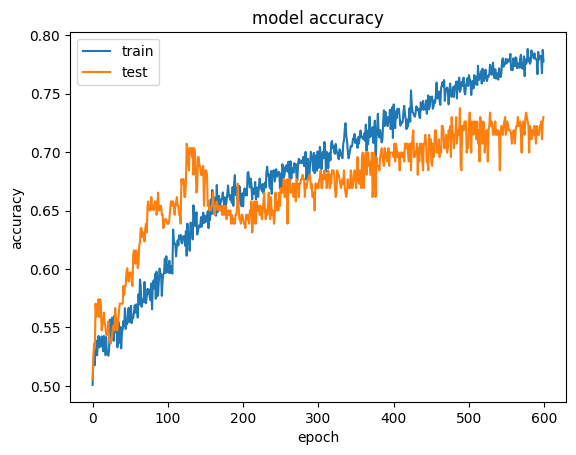

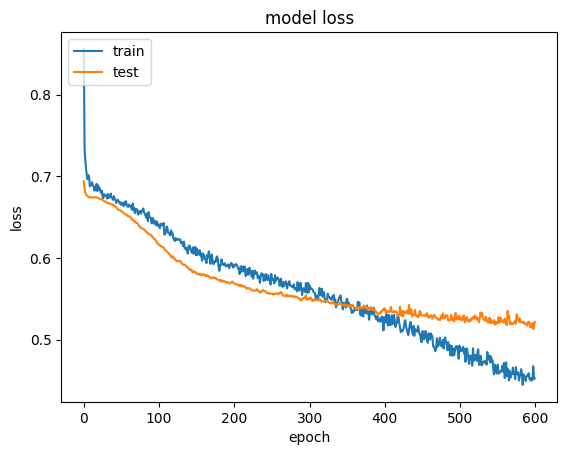

In [60]:
# list all data in history_simple
print(history_simple.history.keys())
# summarize history_simple for accuracy
plt.plot(history_simple.history['acc'])
plt.plot(history_simple.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history_simple for loss
plt.plot(history_simple.history['loss'])
plt.plot(history_simple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()